# Age, Cholesterol, Blood Pressure, and Chest Pain in Determining Heart Disease

Andy Hong, Celine Li, Jason Shi, Ibrahim Saeed

# Preliminary Data Analysis

In [1]:
# Here we load the packages necessary to run our functions
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Preliminary Exploratory Data Analysis

In the code below, we can prove that the dataset can be read from the web. We will be naming the dataset "heart_data". 


In [2]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                       col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We notice that there are no column names for the data set thus we will need to add column names based on what each column represents.

In [3]:
names <- c("age","sex","cp","trestbps",
           "chol","fbs","restecg","thalach",
           "exang","oldpeak","slope",
           "ca","thal","num")

colnames(heart_data) <- names
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Let's select for the columns we are interested in and tidy it up. Note that the "num" column tells us the prescence of heart disease within a patient, with a value of 0 meaning no heart disease present and a value of 1 meaning heart disease is present with greater values representing how significant the prescence is all the way up to the maximum value of 4. 

In [4]:
heart_data_select <- select(heart_data, age, cp, trestbps, chol, num) 
slice(heart_data_select,1:5)


age,cp,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,145,233,0
67,4,160,286,2
67,4,120,229,1
37,3,130,250,0
41,2,130,204,0


Each row is one unique obsevation and each cell only contains one value. But we are only interested in whether a patient has heart diesease or not. Let's transform the "num" column so that values equal to 0 mean no heart diesease is present whereas any values higher means heart diesease is present. 

In [20]:
heart_clean <- heart_data_select |>
               mutate(diag = factor(ifelse(is.na(num), NA,  (num > 0)))) |>
               select(-num)

heart_clean_predSel <- heart_data |>
                       mutate(diag = factor(ifelse(is.na(num), NA,  (num > 0)))) |>
                       select(-num,-sex,-thal,-ca)
heart_clean_predSel



age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,2,150,0,2.3,3,FALSE
67,4,160,286,0,2,108,1,1.5,2,TRUE
67,4,120,229,0,2,129,1,2.6,2,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,131,0,0,115,1,1.2,2,TRUE
57,2,130,236,0,2,174,0,0.0,2,TRUE
38,3,138,175,0,0,173,0,0.0,1,FALSE


Now let's check to see if any missing values. To do this, we can inbed the is.na() function into the sum() function. 

In [6]:
sum(is.na(heart_data_select))

[1] 0

The value 0 tells us that there are no missing values in our data frame. 

Let's separate our training data from the testing data, set a seed, and summarize the training idea to get a good idea of what we are working with.

In [7]:
#splitting dataframe into training, testing datasets
set.seed(1)

heart_split <- initial_split(heart_clean, prop = 3/4, strata = diag)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_clean

age,cp,trestbps,chol,diag
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,FALSE
67,4,160,286,TRUE
67,4,120,229,TRUE
⋮,⋮,⋮,⋮,⋮
57,4,130,131,TRUE
57,2,130,236,TRUE
38,3,138,175,FALSE


We then can summarize this data into a table below.

In [8]:
#summarizing training data into a table and getting mean, min, max
heart_summarized <- heart_training %>%
group_by(diag) %>%
summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
          min_cp  = min(cp), max_cp = max(cp), mean_cp = mean(cp),
          min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
          min_trestbps = min(trestbps), max_trestbps = max(trestbps), 
                             mean_trestbps = mean(trestbps), no_patients = n())
heart_summarized
          
          


diag,min_age,max_age,mean_age,min_cp,max_cp,mean_cp,min_chol,max_chol,mean_chol,min_trestbps,max_trestbps,mean_trestbps,no_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,76,52.96748,1,4,2.788618,157,417,243.9106,94,180,130.4553,123
TRUE,35,77,57.23077,1,4,3.596154,131,407,250.5673,100,180,135.5096,104


We see that there are no anomalies and the number of observations with respect to the diagnosis value (whether or not the patent has heart diesease) is fair. "no_patients" tells us the number of rows. 

In [9]:
# #Plotting this data to find correlation of diagnosis
# options(repr.plot.width = 8, repr.plot.height = 7)

# # RColorBrewer features for color blindness 
# library(RColorBrewer)


# graph <- ggplot(heart_training, aes(x = age, fill = diag, color = diag)) +
#                  geom_histogram() +
#                  labs(x = "Age (years)", y = "Number of patients", color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Age") +
#                  theme(text = element_text(size = 15)) +
#                  scale_fill_brewer(palette = "Dark2") 

# graph2 <- ggplot(heart_training, aes(x = cp, color = diag, fill = diag)) +
#                  geom_histogram(bins = 15) +
#                  labs(x = "Chest Pain", y = "Number of patients", color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Chest Pains") +
#                  theme(text = element_text(size = 15))+
#                  scale_fill_brewer(palette = "Dark2") 

# graph3 <- ggplot(heart_training, aes(x = trestbps, color = diag, fill = diag)) +
#                  geom_histogram() +
#                  labs(x = "Age (years)", y = "Number of patients",
#                       color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Resting Blood Pressure") +
#                  theme(text = element_text(size = 15))+
#                  scale_fill_brewer(palette = "Dark2") 

# graph4 <- ggplot(heart_training, aes(x = chol,  color = diag, fill = diag)) +
#                  geom_histogram() +
#                  labs(x = "Cholesterol (mg/dl))", y = "Number of patients", 
#                       color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Cholesterol levels") +
#                  theme(text = element_text(size = 15))+
#                  scale_fill_brewer(palette = "Dark2") 

# graph
# graph2
# graph3
# graph4

-notes to self for this final project

-use a func to align the histograms side by side; there was a func to do this but i forgot but go check 
-use the foward output algorithm to find the num of best predictor variables in ch.6.8 within the textbook
-also they open on tues so can also go tuesday start 3:30 to questions


## Predictor Variable Selection Analysis 

To figure out the best predictor variables to use for our classifier, we will be using the Foward Selection method. 
First, let's select for the predictors we are working with and get the column names of our predictor variables. 

In [21]:
heart_sub <- heart_clean_predSel |>
             select(diag, 
                    c("age","cp","trestbps",
           "chol","fbs","restecg","thalach",
           "exang","oldpeak","slope",
           "diag") )
pred_names <- colnames(heart_sub |> select(-diag))
heart_sub

diag,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,63,1,145,233,1,2,150,0,2.3,3
TRUE,67,4,160,286,0,2,108,1,1.5,2
TRUE,67,4,120,229,0,2,129,1,2.6,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,57,4,130,131,0,0,115,1,1.2,2
TRUE,57,2,130,236,0,2,174,0,0.0,2
FALSE,38,3,138,175,0,0,173,0,0.0,1


Now let's create a model formula using the paste function. We will be naming this heart_formula.

In [22]:
heart_formula <- paste("diag", "~", paste(pred_names, collapse = "+"))
heart_formula

[1] "diag ~ age+cp+trestbps+chol+fbs+restecg+thalach+exang+oldpeak+slope"

Lastly, we will create the code to find the best predictors for our purposes. 
(Note: Scaffolding of code provided from datasciencebook.ca and this will be properly cited under references)

In [23]:
# Empty tibble to store our results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Here, we create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# Here, we use a 5-fold cross validation for the sake of time and computational power 
heart_vfold <- vfold_cv(heart_sub, v = 5, strata = diag)

# Stores number of total predictors
n_total <- length(pred_names)

# Stores the selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
# for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(pred_names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, pred_names[[j]])
        model_string <- paste("diag", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_sub) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, pred_names[[jstar]])
    pred_names <- pred_names[-jstar]
}
accuracies


size,model_string,accuracy
<int>,<chr>,<dbl>
1,diag ~ cp,0.7585440
2,diag ~ cp+trestbps,0.7619339
3,diag ~ cp+trestbps+fbs,0.7586552
⋮,⋮,⋮
8,diag ~ cp+trestbps+fbs+oldpeak+exang+restecg+thalach+age,0.7887191
9,diag ~ cp+trestbps+fbs+oldpeak+exang+restecg+thalach+age+chol,0.7884968
10,diag ~ cp+trestbps+fbs+oldpeak+exang+restecg+thalach+age+chol+slope,0.7819394


Let's plot the number of predictors against the estimated accuracy to see which group of predictors let us obtain the highest accuracy.

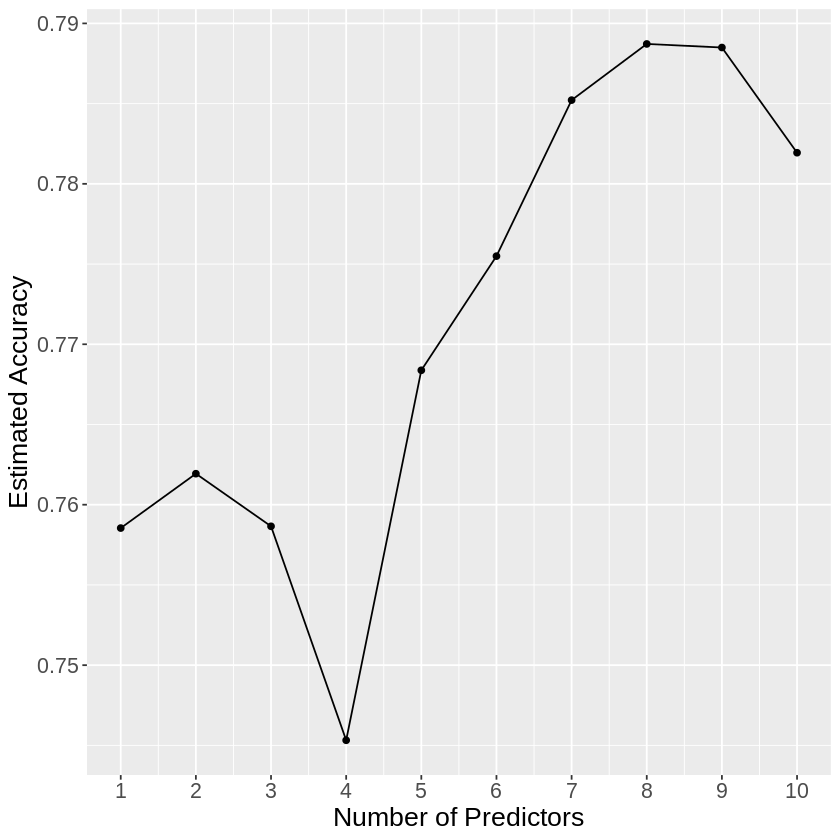

In [34]:
best_pred_plot <- accuracies |>
                  ggplot( aes(x = size, y = accuracy)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Number of Predictors", y = "Estimated Accuracy") +
                  theme(text = element_text(size = 16)) +
                  scale_x_continuous(breaks = seq(0, 10, by = 1))
best_pred_plot

From this plot, we see that when we use these *"8"* predictors: (Type all the predicors here), we obtain the highest accuracy and thus for our classification problem these are the predictor variables that we shall use when building our model. 



(Note: Above I used all the variables except sex, ca, and thal; result took incredibly long to compute though; originally I used age,cp,trestbps, and chol and on highest obtained a 76% accuracy; here is a screenshot link to see my results originally: https://prnt.sc/zeWsy5Jv6TaY ; latter result took much shorter to run but still around ~1-2min)

